# Load modules and data

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

16180


In [2]:
#  load processed chromsome and spots


#load data from saved files

spots_save_folder = r'\\10.245.74.40\Turing3\Pu\Analyzed_Data\20210624-P_Forebrain_smFISH_CTP09\Spots'

saved_filenames = [_file for _file in glob.glob(spots_save_folder + os.sep + '*') ]


spot_saved_filenames =  [_file for _file in saved_filenames if 'spots_hzxyidap' in _file]

chrom_saved_filenames =  [_file for _file in saved_filenames if 'chrom_rna' in _file]

_fov_ids =np.concatenate((np.arange(2,8),np.arange(11,19),np.arange(21,29),np.arange(30,39),
                         np.array([63,64,66,67,68,70]),np.arange(83,89)))

print(len(spot_saved_filenames))
print(len(chrom_saved_filenames))
print(len(_fov_ids))


# make result dict
_spots_hzxyidap_dict_all = {}
_chrom_azxyiuc_dict_all = {}


# generate dict to store results for different fovs
for _fov_id, _file in zip(_fov_ids, spot_saved_filenames):
    _spots_hzxyidap_dict_all[_fov_id] = np.load(_file)
    
for _fov_id, _file in zip(_fov_ids, chrom_saved_filenames):
    _chrom_azxyiuc_dict_all[_fov_id] = np.load(_file)

43
43
43


### annotations for _spots_hzxyidap_dict_all and _chrom_azxyiuc_dict_all


###_spots_hzxyidap_dict_all[[_fov_id]:  

N * 8 ndarray for all spots:
N: number of all spots; 
   for each spot: the 8 elements are [intensity, z, y, x, region id, unique chr id for the closest chr center,
   unique chr id for the assgined chr center, unique chr id for the picked chr center]



###_chrom_azxyiuc_dict_all[_fov_id]:

N * 13 ndarray for all chr centers:
N: number of all chr centers;
   for each chr center: the 13 elements are [chr center label size, z, y, x, gene id, chr unique id, chr cluster id, 
   aligned y in pixel, aligned x in pixel, assigned cell id, slc17a7 rna count, slc32a1 rna count, sst rna count]
   
   
   
   
### How to use:

Use _chrom_azxyiuc_dict_all's  slc17a7 rna count [ind 10], slc32a1 rna count [ind 11], sst rna count [ind 12] to call cell types;

Use _chrom_azxyiuc_dict_all's  gene id [ind 4] to specifiy gene, and chr unique id [ind 5] to find all spots for picked for the specified chr in the _spots_hzxyidap_dict_all.



# Define fovs for cortex

In [3]:
# select fovs from cortex

_filtered_fov_ids = [2,  3,  4,  5,  6,  7, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23,
       24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38]


In [4]:
# define rna count threshold

slc17a7_pos_th = 30
slc17a7_neg_th = 10

slc32a1_pos_th = 10
slc32a1_neg_th = 1

sst_pos_th = 10
sst_neg_th = 1


junk_th = 300

## Compare excitatory and inhibitory neurons

In [7]:
# define gene_id  Slc17a7

_gid = 3


<IPython.core.display.Javascript object>


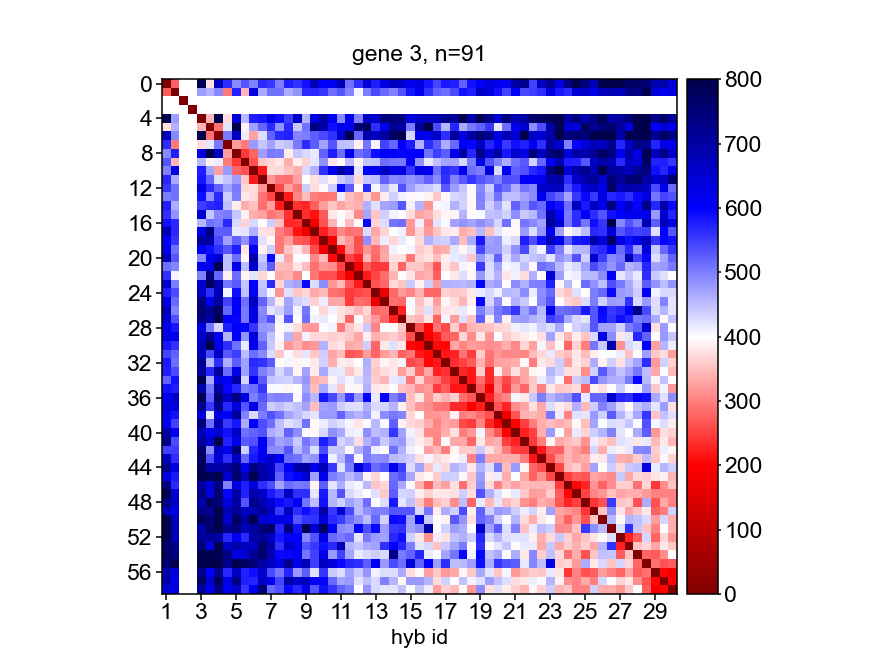

In [8]:
# excitatory neurons

from scipy.spatial.distance import pdist, squareform

kept_chr_ids = []
bad_spot_percentage_th = 0.4

distmap_list = []

for _fov_id in _filtered_fov_ids:
    
    _spots_hzxyidap = _spots_hzxyidap_dict_all[_fov_id]

    _labeled_chrom_rna= _chrom_azxyiuc_dict_all[_fov_id]
    
    # excitatory based on positive Slc17a7
    _chr_type =_labeled_chrom_rna[_labeled_chrom_rna[:,10]>slc17a7_pos_th] 
    
    # filtering out cells near junk
    _chr_type=_chr_type[_chr_type[:,10]<junk_th]

    # further filtering out positive slc32a1 and sst
    _chr_type = _chr_type[_chr_type[:,11]<slc32a1_pos_th]
    _chr_type = _chr_type[_chr_type[:,12]<sst_pos_th]
    
    
    # specify gene
    _all_chr_gene=_chr_type[_chr_type[:,4]==_gid]

    _all_chr_id_gene = np.unique(_all_chr_gene[:,5])
                                                    
    #_chr_count +=len(_all_chr_id_gene)                                        
                           
        
    #for _chr_id in _all_chr_id_gene:
    _subset_chr_num = 6
    _subset_chr_id_gene = np.random.choice(_all_chr_id_gene, _subset_chr_num)
    
    # use a subset of chr by slicing if number of chr are too different between conditions
    for _chr_id in _subset_chr_id_gene:   # OR    'for _chr_id in _all_chr_id_gene:'   for all chrs
        
 
        _spot_chr = _spots_hzxyidap[_spots_hzxyidap[:,-1]==_chr_id].copy()
    
        zxy_chr_list = []
        
        for _region_id in np.arange(1,60):   #use [0:20] slicing for gene 4 which is shorter
                
            if _region_id in _spot_chr[:,4] and _region_id not in [3,4]: # skip region 3 and 4 
                _good_spot = _spot_chr[_spot_chr[:,4]==_region_id].ravel()
                zxy_chr_list.append(_good_spot[1:4])
            else:
                zxy_chr_list.append(np.array([np.nan,np.nan,np.nan]))
            
        zxy_chr_list= np.array(zxy_chr_list)  # the zyx_chr_list for other analysis
        
    
        if np.mean(np.isnan(zxy_chr_list).sum(1)>0) < bad_spot_percentage_th:
            kept_chr_ids.append(True)
            distmap_list.append(squareform(pdist(zxy_chr_list[:])))
        else:
            kept_chr_ids.append(False)
        
        
        
kept_chr_ids = np.array(kept_chr_ids, dtype=bool)            
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)    

median_distmap_c =median_distmap

kept_inds = np.arange(len(np.arange(1,60)))#    #[32:52] slicing if zooming for gene 3 (slc17a7) which locates near region 43


fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,800],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"gene {_gid}, n={len(distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 4)

ax.set_xticks(_ticks)
ax.set_xticklabels(np.array((np.arange(1,60)[kept_inds][_ticks]-1)/2+1, dtype=np.int32))
ax.set_xlabel(f"hyb id", fontsize=7, labelpad=2)

ax.set_yticks(_ticks)

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

In [9]:
_all_chr_id_gene

array([254., 256., 276., 277., 287., 296., 307., 310., 312., 326., 329.,
       339., 341., 344., 345., 348., 354., 355., 356.])

In [10]:
_all_chr_id_gene

_subset_chr_num = 5
_subset_chr_id_gene = np.random.choice(_all_chr_id_gene, _subset_chr_num)

_subset_chr_id_gene

array([345., 348., 339., 276., 341.])

<IPython.core.display.Javascript object>


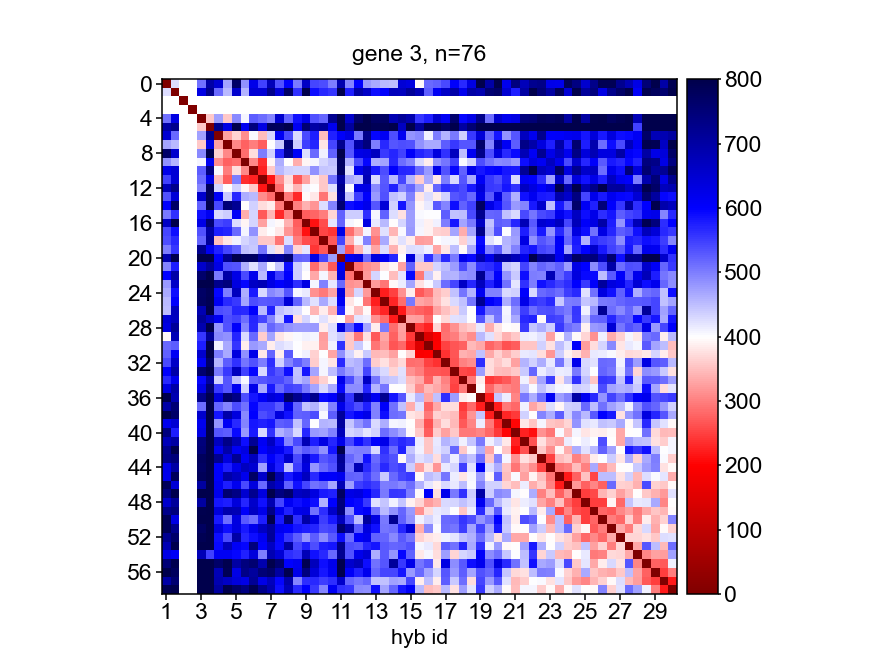

In [11]:
# inhibitory neurons


from scipy.spatial.distance import pdist, squareform

kept_chr_ids = []
bad_spot_percentage_th = 0.4

distmap_list = []

for _fov_id in _filtered_fov_ids:
    
    _spots_hzxyidap = _spots_hzxyidap_dict_all[_fov_id]

    _labeled_chrom_rna= _chrom_azxyiuc_dict_all[_fov_id]
    
    # inhibitory based on positive Slc32a1
    _chr_type =_labeled_chrom_rna[_labeled_chrom_rna[:,11]>slc32a1_pos_th] 
    
    # filtering out cells near junk
    _chr_type=_chr_type[_chr_type[:,11]<junk_th]

    # further filtering out positive slc17a7
    _chr_type = _chr_type[_chr_type[:,10]<slc17a7_pos_th]
    
    
    
    # specify gene
    _all_chr_gene=_chr_type[_chr_type[:,4]==_gid]

    _all_chr_id_gene = np.unique(_all_chr_gene[:,5])
                                                    
    #_chr_count +=len(_all_chr_id_gene)                                        
                           
        
    for _chr_id in _all_chr_id_gene:   # use a subset of chr by slicing if number of chr are too different between conditions
 
        _spot_chr = _spots_hzxyidap[_spots_hzxyidap[:,-1]==_chr_id].copy()
    
        zxy_chr_list = []
        
        for _region_id in np.arange(1,60):   #use [0:20] slicing for gene 4 which is shorter
                
            if _region_id in _spot_chr[:,4] and _region_id not in [3,4]: # skip region 3 and 4 
                _good_spot = _spot_chr[_spot_chr[:,4]==_region_id].ravel()
                zxy_chr_list.append(_good_spot[1:4])
            else:
                zxy_chr_list.append(np.array([np.nan,np.nan,np.nan]))
            
        zxy_chr_list= np.array(zxy_chr_list)  # the zyx_chr_list for other analysis
        
    
        if np.mean(np.isnan(zxy_chr_list).sum(1)>0) < bad_spot_percentage_th:
            kept_chr_ids.append(True)
            distmap_list.append(squareform(pdist(zxy_chr_list[:])))
        else:
            kept_chr_ids.append(False)
        
        
        
kept_chr_ids = np.array(kept_chr_ids, dtype=bool)            
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)    

median_distmap_c =median_distmap

kept_inds = np.arange(len(np.arange(1,60)))#    #[32:52] slicing if zooming for gene 3 (slc17a7) which locates near region 43


fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,800],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"gene {_gid}, n={len(distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 4)

ax.set_xticks(_ticks)
ax.set_xticklabels(np.array((np.arange(1,60)[kept_inds][_ticks]-1)/2+1, dtype=np.int32))
ax.set_xlabel(f"hyb id", fontsize=7, labelpad=2)

ax.set_yticks(_ticks)

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

In [12]:
# define gene_id  Slc32a1

_gid = 4

<IPython.core.display.Javascript object>


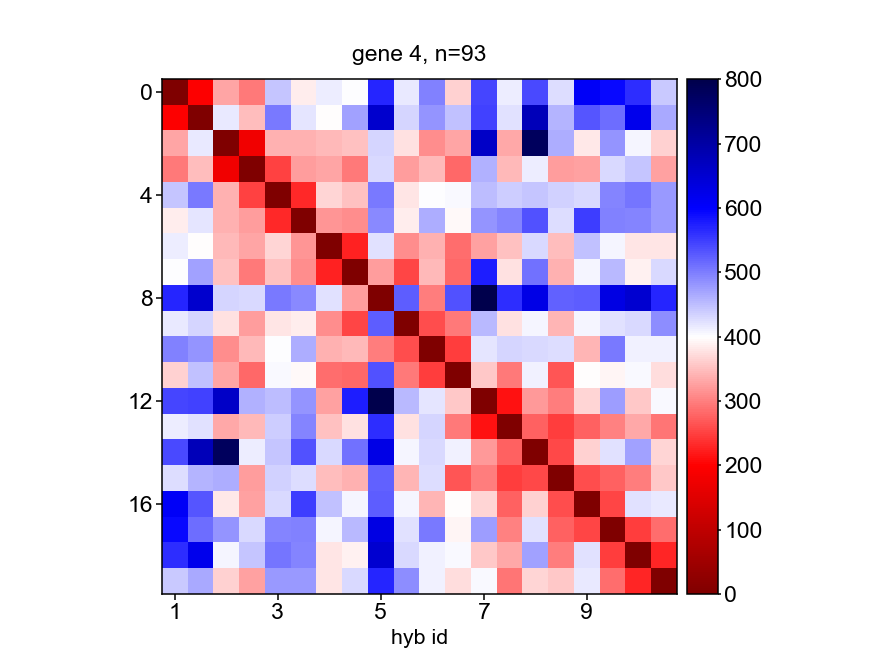

In [13]:
# excitatory neurons

from scipy.spatial.distance import pdist, squareform

kept_chr_ids = []
bad_spot_percentage_th = 0.4

distmap_list = []

for _fov_id in _filtered_fov_ids:
    
    _spots_hzxyidap = _spots_hzxyidap_dict_all[_fov_id]

    _labeled_chrom_rna= _chrom_azxyiuc_dict_all[_fov_id]
    
    # excitatory based on positive Slc17a7
    _chr_type =_labeled_chrom_rna[_labeled_chrom_rna[:,10]>slc17a7_pos_th] 
    
    # filtering out cells near junk
    _chr_type=_chr_type[_chr_type[:,10]<junk_th]

    # further filtering out positive slc32a1 and sst
    _chr_type = _chr_type[_chr_type[:,11]<slc32a1_pos_th]
    _chr_type = _chr_type[_chr_type[:,12]<sst_pos_th]
    
    
    # specify gene
    _all_chr_gene=_chr_type[_chr_type[:,4]==_gid]

    _all_chr_id_gene = np.unique(_all_chr_gene[:,5])
                                                    
    #_chr_count +=len(_all_chr_id_gene)                                        
                           
        
    #for _chr_id in _all_chr_id_gene:   
    # can use a subset of chr by slicing if number of chr are too different between conditions
    
    #for _chr_id in _all_chr_id_gene:
    _subset_chr_num = 7
    _subset_chr_id_gene = np.random.choice(_all_chr_id_gene, _subset_chr_num)
    
    # use a subset of chr by slicing if number of chr are too different between conditions
    for _chr_id in _subset_chr_id_gene:    # OR    'for _chr_id in _all_chr_id_gene:'   for all chrs
 
        _spot_chr = _spots_hzxyidap[_spots_hzxyidap[:,-1]==_chr_id].copy()
    
        zxy_chr_list = []
        
        for _region_id in np.arange(1,60)[:20]:   #use [0:20] slicing for gene 4 which is shorter
                
            if _region_id in _spot_chr[:,4]: # keep region 3 and 4 
                _good_spot = _spot_chr[_spot_chr[:,4]==_region_id].ravel()
                zxy_chr_list.append(_good_spot[1:4])
            else:
                zxy_chr_list.append(np.array([np.nan,np.nan,np.nan]))
            
        zxy_chr_list= np.array(zxy_chr_list)  # the zyx_chr_list for other analysis
        
    
        if np.mean(np.isnan(zxy_chr_list).sum(1)>0) < bad_spot_percentage_th:
            kept_chr_ids.append(True)
            distmap_list.append(squareform(pdist(zxy_chr_list[:])))
        else:
            kept_chr_ids.append(False)
        
        
        
kept_chr_ids = np.array(kept_chr_ids, dtype=bool)            
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)    

median_distmap_c =median_distmap

kept_inds = np.arange(len(np.arange(1,60)))[:20]#    #[32:52] slicing if zooming for gene 3 (slc17a7) which locates near region 43


fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,800],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"gene {_gid}, n={len(distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 4)

ax.set_xticks(_ticks)
ax.set_xticklabels(np.array((np.arange(1,60)[kept_inds][_ticks]-1)/2+1, dtype=np.int32))
ax.set_xlabel(f"hyb id", fontsize=7, labelpad=2)

ax.set_yticks(_ticks)

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

<IPython.core.display.Javascript object>


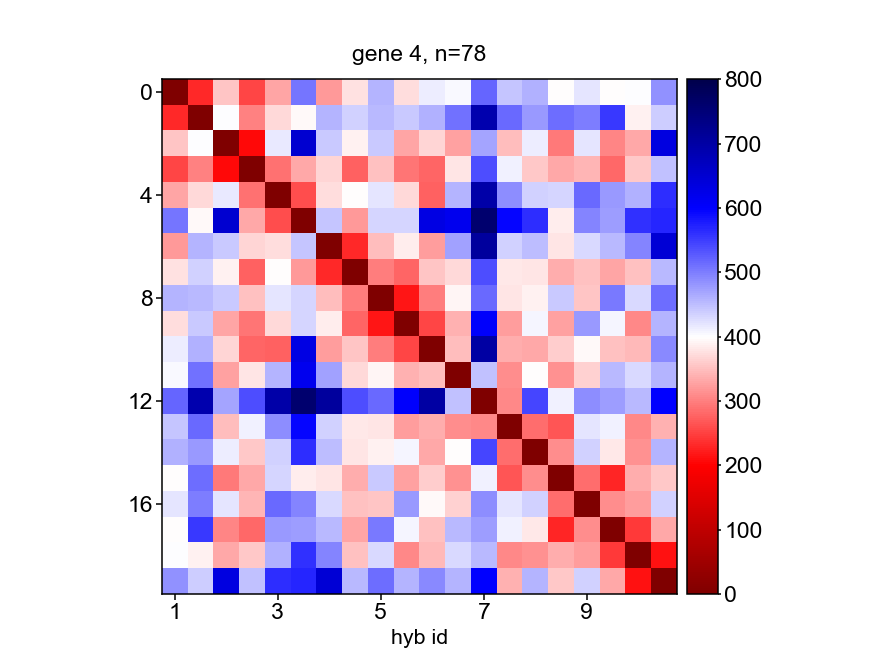

In [14]:
# inhibitory neurons


from scipy.spatial.distance import pdist, squareform

kept_chr_ids = []
bad_spot_percentage_th = 0.4

distmap_list = []

for _fov_id in _filtered_fov_ids:
    
    _spots_hzxyidap = _spots_hzxyidap_dict_all[_fov_id]

    _labeled_chrom_rna= _chrom_azxyiuc_dict_all[_fov_id]
    
    # inhibitory based on positive Slc32a1
    _chr_type =_labeled_chrom_rna[_labeled_chrom_rna[:,11]>slc32a1_pos_th] 
    
    # filtering out cells near junk
    _chr_type=_chr_type[_chr_type[:,11]<junk_th]

    # further filtering out positive slc17a7
    _chr_type = _chr_type[_chr_type[:,10]<slc17a7_pos_th]
    
    
    
    # specify gene
    _all_chr_gene=_chr_type[_chr_type[:,4]==_gid]

    _all_chr_id_gene = np.unique(_all_chr_gene[:,5])
                                                    
    #_chr_count +=len(_all_chr_id_gene)                                        
                           
        
    for _chr_id in _all_chr_id_gene:   # use a subset of chr by slicing if number of chr are too different between conditions
 
        _spot_chr = _spots_hzxyidap[_spots_hzxyidap[:,-1]==_chr_id].copy()
    
        zxy_chr_list = []
        
        for _region_id in np.arange(1,60)[0:20]:   #use [0:20] slicing for gene 4 which is shorter
                
            if _region_id in _spot_chr[:,4]: # keep region 3 and 4 
                _good_spot = _spot_chr[_spot_chr[:,4]==_region_id].ravel()
                zxy_chr_list.append(_good_spot[1:4])
            else:
                zxy_chr_list.append(np.array([np.nan,np.nan,np.nan]))
            
        zxy_chr_list= np.array(zxy_chr_list)  # the zyx_chr_list for other analysis
        
    
        if np.mean(np.isnan(zxy_chr_list).sum(1)>0) < bad_spot_percentage_th:
            kept_chr_ids.append(True)
            distmap_list.append(squareform(pdist(zxy_chr_list[:])))
        else:
            kept_chr_ids.append(False)
        
        
        
kept_chr_ids = np.array(kept_chr_ids, dtype=bool)            
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)    

median_distmap_c =median_distmap

kept_inds = np.arange(len(np.arange(1,60)))[0:20]#    #[32:52] slicing if zooming for gene 3 (slc17a7) which locates near region 43


fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,800],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"gene {_gid}, n={len(distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 4)

ax.set_xticks(_ticks)
ax.set_xticklabels(np.array((np.arange(1,60)[kept_inds][_ticks]-1)/2+1, dtype=np.int32))
ax.set_xlabel(f"hyb id", fontsize=7, labelpad=2)

ax.set_yticks(_ticks)

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

## Compare excitatory neurons and glia cells (which are non-excitatory)

In [31]:
# define gene_id  Slc17a7

_gid = 5

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


<IPython.core.display.Javascript object>


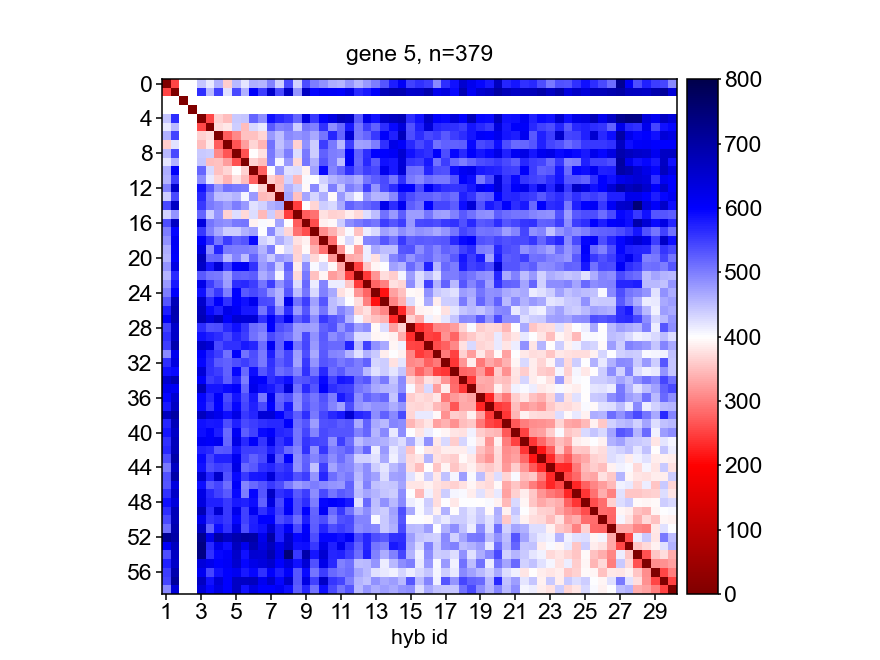

In [32]:
# excitatory neurons

from scipy.spatial.distance import pdist, squareform

kept_chr_ids = []
bad_spot_percentage_th = 0.4

distmap_list = []

for _fov_id in _filtered_fov_ids:
    
    _spots_hzxyidap = _spots_hzxyidap_dict_all[_fov_id]

    _labeled_chrom_rna= _chrom_azxyiuc_dict_all[_fov_id]
    
    # excitatory based on positive Slc17a7
    _chr_type =_labeled_chrom_rna[_labeled_chrom_rna[:,10]>slc17a7_pos_th] 
    
    # filtering out cells near junk
    _chr_type=_chr_type[_chr_type[:,10]<junk_th]

    # further filtering out positive slc32a1 and sst
    _chr_type = _chr_type[_chr_type[:,11]<slc32a1_pos_th]
    _chr_type = _chr_type[_chr_type[:,12]<sst_pos_th]
    
    
    # specify gene
    _all_chr_gene=_chr_type[_chr_type[:,4]==_gid]

    _all_chr_id_gene = np.unique(_all_chr_gene[:,5])
                                                    
    #_chr_count +=len(_all_chr_id_gene)                                        
                           
        
    for _chr_id in _all_chr_id_gene:   # use a subset of chr by slicing if number of chr are too different between conditions
 
        _spot_chr = _spots_hzxyidap[_spots_hzxyidap[:,-1]==_chr_id].copy()
    
        zxy_chr_list = []
        
        for _region_id in np.arange(1,60):   #use [0:20] slicing for gene 4 which is shorter
                
            if _region_id in _spot_chr[:,4] and _region_id not in [3,4]: # skip region 3 and 4 
                _good_spot = _spot_chr[_spot_chr[:,4]==_region_id].ravel()
                zxy_chr_list.append(_good_spot[1:4])
            else:
                zxy_chr_list.append(np.array([np.nan,np.nan,np.nan]))
            
        zxy_chr_list= np.array(zxy_chr_list)  # the zyx_chr_list for other analysis
        
    
        if np.mean(np.isnan(zxy_chr_list).sum(1)>0) < bad_spot_percentage_th:
            kept_chr_ids.append(True)
            distmap_list.append(squareform(pdist(zxy_chr_list[:])))
        else:
            kept_chr_ids.append(False)
        
        
        
kept_chr_ids = np.array(kept_chr_ids, dtype=bool)            
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)    

median_distmap_pos =median_distmap

kept_inds = np.arange(len(np.arange(1,60)))#    #[32:52] slicing if zooming for gene 3 (slc17a7) which locates near region 43


fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,800],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"gene {_gid}, n={len(distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 4)

ax.set_xticks(_ticks)
ax.set_xticklabels(np.array((np.arange(1,60)[kept_inds][_ticks]-1)/2+1, dtype=np.int32))
ax.set_xlabel(f"hyb id", fontsize=7, labelpad=2)

ax.set_yticks(_ticks)

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

<IPython.core.display.Javascript object>


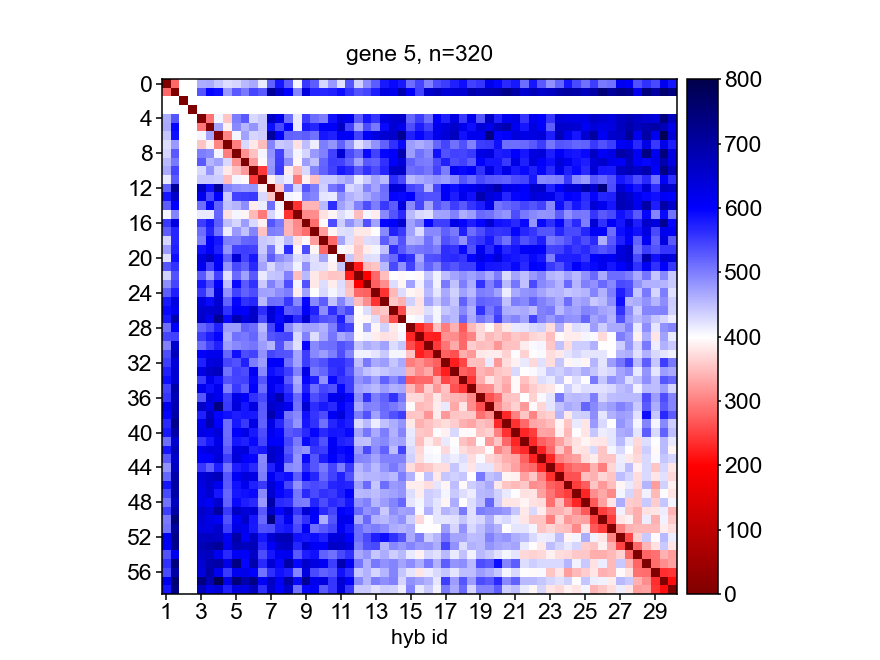

In [37]:
# non-excitatory glial cells

from scipy.spatial.distance import pdist, squareform

kept_chr_ids = []
bad_spot_percentage_th = 0.4

distmap_list = []

for _fov_id in _filtered_fov_ids:
    
    _spots_hzxyidap = _spots_hzxyidap_dict_all[_fov_id]

    _labeled_chrom_rna= _chrom_azxyiuc_dict_all[_fov_id]
    
    # excitatory based on positive Slc17a7
    _chr_type =_labeled_chrom_rna[_labeled_chrom_rna[:,10]<slc17a7_neg_th] 
    
    # filtering out cells near junk
    _chr_type=_chr_type[_chr_type[:,10]<junk_th]

    # further filtering out positive slc32a1 and sst
    _chr_type = _chr_type[_chr_type[:,11]<slc32a1_pos_th]
    _chr_type = _chr_type[_chr_type[:,12]<sst_pos_th]
    
    
    # specify gene
    _all_chr_gene=_chr_type[_chr_type[:,4]==_gid]

    _all_chr_id_gene = np.unique(_all_chr_gene[:,5])
                                                    
    #_chr_count +=len(_all_chr_id_gene)                                        
                           
        
    for _chr_id in _all_chr_id_gene:   # use a subset of chr by slicing if number of chr are too different between conditions
 
        _spot_chr = _spots_hzxyidap[_spots_hzxyidap[:,-1]==_chr_id].copy()
    
        zxy_chr_list = []
        
        for _region_id in np.arange(1,60):   #use [0:20] slicing for gene 4 which is shorter
                
            if _region_id in _spot_chr[:,4] and _region_id not in [3,4]: # skip region 3 and 4 
                _good_spot = _spot_chr[_spot_chr[:,4]==_region_id].ravel()
                zxy_chr_list.append(_good_spot[1:4])
            else:
                zxy_chr_list.append(np.array([np.nan,np.nan,np.nan]))
            
        zxy_chr_list= np.array(zxy_chr_list)  # the zyx_chr_list for other analysis
        
    
        if np.mean(np.isnan(zxy_chr_list).sum(1)>0) < bad_spot_percentage_th:
            kept_chr_ids.append(True)
            distmap_list.append(squareform(pdist(zxy_chr_list[:])))
        else:
            kept_chr_ids.append(False)
        
        
        
kept_chr_ids = np.array(kept_chr_ids, dtype=bool)            
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)    

median_distmap_neg =median_distmap

kept_inds = np.arange(len(np.arange(1,60)))#    #[32:52] slicing if zooming for gene 3 (slc17a7) which locates near region 43


fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,800],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"gene {_gid}, n={len(distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 4)

ax.set_xticks(_ticks)
ax.set_xticklabels(np.array((np.arange(1,60)[kept_inds][_ticks]-1)/2+1, dtype=np.int32))
ax.set_xlabel(f"hyb id", fontsize=7, labelpad=2)

ax.set_yticks(_ticks)

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

<IPython.core.display.Javascript object>


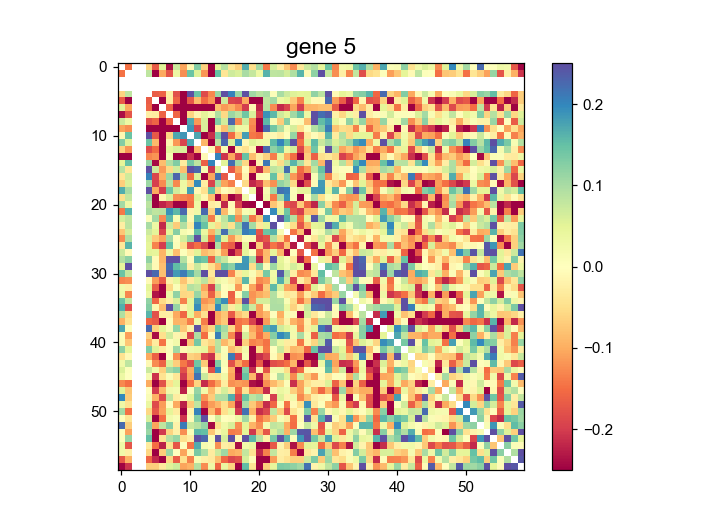

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
plt.figure()
plt.title(f"gene {_gid}", fontsize=15)
plt.imshow(np.log(median_distmap_pos / median_distmap_neg) / np.log(2), vmin=-0.25, vmax=0.25, cmap='Spectral')
plt.colorbar()
plt.show()